In [1]:
import pathlib
import xarray as xr
import glob
import pandas as pd
import netCDF4
import matplotlib.pyplot as plt
import numpy as np
import hvplot.pandas
import hvplot.dask  # noqa
import dask
from scipy import stats
from datetime import datetime
import re


In [2]:
data_dir = pathlib.Path('/home/jovyan/ooi/kdata/RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample')

In [3]:
# Get list of NetCDF files
file_list = list(data_dir.glob("*.nc"))

# Function to extract start date from filename
def extract_start_date(file_path):
    # Extract the date string using regex
    match = re.search(r'_(\d{8}T\d{6})\.\d+-', file_path.name)
    if match:
        date_str = match.group(1)
        # Convert to datetime object
        return datetime.strptime(date_str, '%Y%m%dT%H%M%S')
    return datetime.min  # Fallback date if pattern doesn't match

# Sort files by start date
sorted_files = sorted(file_list, key=extract_start_date)

# Take a subset of chronologically ordered files
netcdf_files_sub = sorted_files[0:3] 

In [4]:
file_list[0:3]

[PosixPath('/home/jovyan/ooi/kdata/RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/deployment0002_RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample_20240204T084530.998350-20240205T084720.951573.nc'),
 PosixPath('/home/jovyan/ooi/kdata/RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/deployment0002_RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample_20240706T085020.410430-20240707T085020.355224.nc'),
 PosixPath('/home/jovyan/ooi/kdata/RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/deployment0002_RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample_20240414T081352.612105-20240415T081152.555764.nc')]

In [5]:
netcdf_files_sub

[PosixPath('/home/jovyan/ooi/kdata/RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/deployment0001_RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample_20140929T190312-20160530T235951.071917.nc'),
 PosixPath('/home/jovyan/ooi/kdata/RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/deployment0001_RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample_20160531T000003.071069-20170724T235956.777524.nc'),
 PosixPath('/home/jovyan/ooi/kdata/RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/deployment0001_RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample_20170725T000001.776108-20170813T232226.349596.nc')]

In [ ]:
# ds = xr.open_mfdataset(
#     netcdf_files_sub,
#     combine='nested',       # Use nested to concatenate along an existing dimension
#     concat_dim='obs',       # Concatenate along the 'obs' dimension
#     compat='override',      # Override any metadata conflicts
#     coords='minimal',       # Use minimal coords
#     join='outer'            # Use outer join to include all variables from all files
# )

# Sort the resulting dataset by time
# ds = ds.sortby('time')

In [11]:
# Time range check
print("Start time:", ds.time.values.min())
print("End time:", ds.time.values.max())
print("Total duration:", ds.time.values.max() - ds.time.values.min())

NameError: name 'ds' is not defined

In [12]:

# Function to extract start date from filename
def extract_start_date(file_path):
    # Extract the date string using regex
    match = re.search(r'_(\d{8}T\d{6})\.\d+-', file_path.name)
    if match:
        date_str = match.group(1)
        # Convert to datetime object
        return datetime.strptime(date_str, '%Y%m%dT%H%M%S')
    return datetime.min  # Fallback date if pattern doesn't match



In [13]:
# Print information about files before sorting
print("File count:", len(file_list))
print("Sample paths:")
for i in range(min(3, len(file_list))):
    print(f"  {file_list[i]}")
    print(f"  Extracted date: {extract_start_date(file_list[i])}")


File count: 892
Sample paths:
  /home/jovyan/ooi/kdata/RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/deployment0002_RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample_20240204T084530.998350-20240205T084720.951573.nc
  Extracted date: 2024-02-04 08:45:30
  /home/jovyan/ooi/kdata/RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/deployment0002_RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample_20240706T085020.410430-20240707T085020.355224.nc
  Extracted date: 2024-07-06 08:50:20
  /home/jovyan/ooi/kdata/RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/deployment0002_RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample_20240414T081352.612105-20240415T081152.555764.nc
  Extracted date: 2024-04-14 08:13:52


In [14]:
# Sort files by start date
sorted_files = sorted(file_list, key=extract_start_date)


In [ ]:

# Debug the sorted order
print("\nFirst 5 sorted files:")
for i in range(min(5, len(sorted_files))):
    print(f"{i+1}. {sorted_files[i].name}")
    print(f"   Date: {extract_start_date(sorted_files[i])}")

# Filter to keep only specific deployment if needed
deployment2_files = [f for f in sorted_files if 'deployment0002' in f.name]
print(f"\nFound {len(deployment2_files)} files from deployment 0002")

# Now you can take a subset of chronologically ordered, filtered files
netcdf_files_sub = deployment2_files[0:3]  # First 3 deployment 0002 files

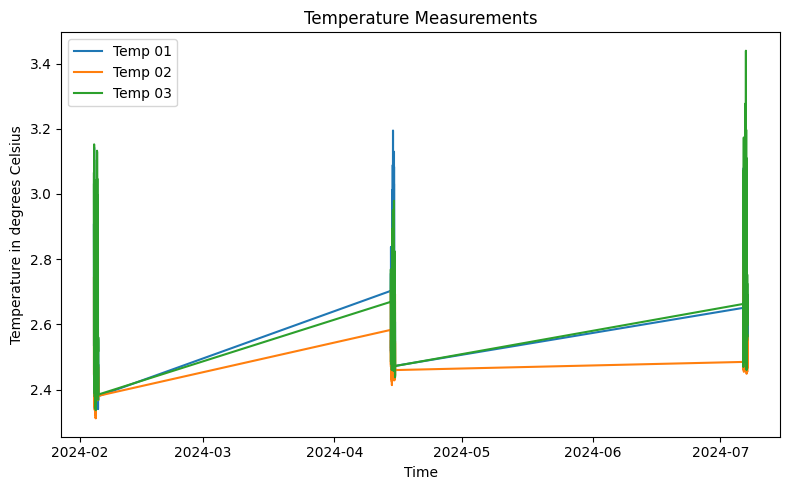

In [53]:
# Plot multiple temperature variables with time on x-axis
plt.figure(figsize=(8, 5))

# Plot each temperature variable against time explicitly
plt.plot(ds.time, ds.temperature01, label='Temp 01')
plt.plot(ds.time, ds.temperature02, label='Temp 02')
plt.plot(ds.time, ds.temperature03, label='Temp 03')

plt.legend()
plt.title('Temperature Measurements')
plt.xlabel('Time')
plt.ylabel('Temperature in degrees Celsius')
plt.tight_layout()
plt.show()

892

In [24]:
combined_ds = xr.open_mfdataset(netcdf_files_sub)

In [20]:
ds

<xarray.Dataset> Size: 3MB
Dimensions:                    (obs: 8652)
Coordinates:
  * obs                        (obs) int32 35kB 0 1 2 3 ... 8648 8649 8650 8651
    time                       (obs) datetime64[ns] 69kB ...
Data variables: (12/83)
    temperature14_qc_executed  (obs) uint8 9kB ...
    battery_voltage            (obs) float32 35kB ...
    temperature06_qc_executed  (obs) uint8 9kB ...
    temperature23              (obs) float32 35kB ...
    temperature10_qc_executed  (obs) uint8 9kB ...
    temperature24_qc_executed  (obs) uint8 9kB ...
    ...                         ...
    temperature19_qc_executed  (obs) uint8 9kB ...
    temperature18_qc_results   (obs) uint8 9kB ...
    temperature21              (obs) float32 35kB ...
    temperature09_qc_results   (obs) uint8 9kB ...
    temperature15_qc_executed  (obs) uint8 9kB ...
    temperature20              (obs) float32 35kB ...
Attributes: (12/70)
    node:                               MJ03B
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  streamed
    stream:                             tmpsf_sample
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                45.93365
    lon:                                -130.01369

In [5]:
for file in netcdf_files_sub:
    ds = xr.open_dataset(file)
    print(ds['temperature03']) #I kept getting an error with temperature03 and wanted to check the details for it

<xarray.DataArray 'temperature03' (obs: 8652)> Size: 35kB
[8652 values with dtype=float32]
Coordinates:
  * obs      (obs) int32 35kB 0 1 2 3 4 5 6 ... 8646 8647 8648 8649 8650 8651
    time     (obs) datetime64[ns] 69kB ...
Attributes:
    comment:    Seawater Temperature in Spatial Grid 03 is temperature measur...
    precision:  4
    long_name:  Seawater Temperature in Spatial Grid 03
    units:      degrees_Celsius
<xarray.DataArray 'temperature03' (obs: 8641)> Size: 35kB
[8641 values with dtype=float32]
Coordinates:
  * obs      (obs) int32 35kB 0 1 2 3 4 5 6 ... 8635 8636 8637 8638 8639 8640
    time     (obs) datetime64[ns] 69kB ...
Attributes:
    comment:    Seawater Temperature in Spatial Grid 03 is temperature measur...
    precision:  4
    long_name:  Seawater Temperature in Spatial Grid 03
    units:      degrees_Celsius
<xarray.DataArray 'temperature03' (obs: 8629)> Size: 35kB
[8629 values with dtype=float32]
Coordinates:
  * obs      (obs) int32 35kB 0 1 2 3 4 5 6 ... 

In [7]:
combined_ds = xr.open_mfdataset(netcdf_files_sub, combine='by_coords', compat='minimal')
combined_ds = combined_ds.swap_dims({'obs': 'time'}) 
    #swapping dimensions
combined_ds = combined_ds.chunk({'time': 1000})
    #chunk the time
combined_ds = combined_ds.sortby('time')

combined_ds

<xarray.Dataset>
Dimensions:                        (time: 8589)
Coordinates:
    obs                            (time) int32 dask.array<chunksize=(1000,), meta=np.ndarray>
Dimensions without coordinates: time
Data variables: (12/48)
    temperature20_qartod_executed  (time) object dask.array<chunksize=(1000,), meta=np.ndarray>
    temperature19_qartod_results   (time) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
    temperature20_qartod_results   (time) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
    temperature11_qartod_executed  (time) object dask.array<chunksize=(1000,), meta=np.ndarray>
    temperature06_qartod_executed  (time) object dask.array<chunksize=(1000,), meta=np.ndarray>
    temperature03_qartod_executed  (time) object dask.array<chunksize=(1000,), meta=np.ndarray>
    ...                             ...
    temperature10_qartod_executed  (time) object dask.array<chunksize=(1000,), meta=np.ndarray>
    temperature09_qartod_results   (time) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
    temperature07_qartod_executed  (time) object dask.array<chunksize=(1000,), meta=np.ndarray>
    temperature08_qartod_executed  (time) object dask.array<chunksize=(1000,), meta=np.ndarray>
    temperature23_qartod_executed  (time) object dask.array<chunksize=(1000,), meta=np.ndarray>
    temperature02_qartod_executed  (time) object dask.array<chunksize=(1000,), meta=np.ndarray>
Attributes: (12/70)
    node:                               MJ03B
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  streamed
    stream:                             tmpsf_sample
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                45.93365
    lon:                                -130.01369

In [11]:
df_tmpsf=combined_ds[['time', 'temperature01', 'temperature02', 'temperature03','temperature04','temperature05','temperature06','temperature07','temperature08','temperature09','temperature10','temperature11','temperature12','temperature13','temperature14','temperature15','temperature02','temperature16','temperature17','temperature18','temperature19','temperature20','temperature21','temperature22','temperature23','temperature24']].to_pandas()

In [12]:
df_tmpsf

,temperature01,temperature02,temperature03,temperature04,temperature05,temperature06,temperature07,temperature08,temperature09,temperature10,...,temperature16,temperature17,temperature18,temperature19,temperature20,temperature21,temperature22,temperature23,temperature24,obs
time,,,,,,,,,,,,,,,,,,,,,
2023-06-29 08:41:59.366781952,4.3668,3.6829,3.1798,2.4102,2.4732,2.4494,2.9671,3.2684,2.3812,2.3687,...,3.9785,2.3830,2.3726,2.3655,2.3641,2.3824,2.3925,2.3631,2.3810,0
2023-06-29 08:42:09.366830592,4.3557,3.7100,3.1225,2.4123,2.4739,2.4477,2.9693,3.2733,2.3806,2.3689,...,3.9199,2.3813,2.3727,2.3663,2.3639,2.3820,2.3919,2.3628,2.3794,1
2023-06-29 08:42:19.368572928,4.3412,3.7371,3.0723,2.4125,2.4736,2.4473,2.9720,3.2701,2.3794,2.3703,...,3.8582,2.3802,2.3728,2.3661,2.3635,2.3817,2.3921,2.3631,2.3781,2
2023-06-29 08:42:29.366295040,4.3244,3.7648,3.0304,2.4111,2.4738,2.4470,2.9738,3.2620,2.3798,2.3697,...,3.7979,2.3794,2.3728,2.3660,2.3633,2.3814,2.3919,2.3625,2.3766,3
2023-06-29 08:42:39.367684096,4.3020,3.7942,2.9943,2.4112,2.4738,2.4445,2.9775,3.2467,2.3798,2.3698,...,3.7389,2.3778,2.3720,2.3652,2.3628,2.3813,2.3920,2.3621,2.3754,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30 08:42:29.318060544,2.8855,3.4469,5.2381,2.3828,2.4663,2.4465,2.6799,2.4305,2.3856,2.3781,...,2.5337,2.3775,2.3836,2.3764,2.3735,2.3827,2.3997,2.3707,2.3766,8611
2023-06-30 08:42:39.317320192,2.8965,3.4388,5.2648,2.3842,2.4663,2.4467,2.6715,2.4273,2.3854,2.3782,...,2.5227,2.3774,2.3840,2.3760,2.3729,2.3825,2.4000,2.3716,2.3770,8612
2023-06-30 08:42:49.318196224,2.9054,3.4282,5.2892,2.3838,2.4647,2.4459,2.6627,2.4247,2.3853,2.3784,...,2.5130,2.3769,2.3842,2.3765,2.3739,2.3825,2.4005,2.3717,2.3771,8613


In [18]:
df_tmpsf.rename(columns={'temperature01':'t01','temperature02':'t02', 'temperature03':'t03'
                         ,'temperature04':'t04','temperature05':'t05','temperature06':'t06'
                         ,'temperature07':'t07','temperature08':'t08','temperature09':'t09'
                         ,'temperature10':'t10','temperature11':'t11','temperature12':'t12'
                         ,'temperature13':'t13','temperature14':'t14','temperature15':'t15'
                         ,'temperature16':'t16','temperature17':'t17','temperature18':'t18'
                         ,'temperature19':'t19','temperature20':'t20','temperature21':'t21'
                         ,'temperature22':'t22','temperature23':'t23','temperature24':'t24'}, inplace=True)
df_tmpsf.index=pd.to_datetime(df_tmpsf.index)
df_tmpsf = df_tmpsf.drop_duplicates(keep='first', inplace=False, ignore_index=False)
df_tmpsf['tl1'] = df_tmpsf[['t01', 't02', 't03', 't04', 't05', 't06', 't07']].mean(axis=1)
df_tmpsf['tl2'] = df_tmpsf[['t08', 't09', 't10', 't11', 't12', 't13', 't14']].mean(axis=1)
df_tmpsf['tl3'] = df_tmpsf[['t15', 't16', 't17', 't18', 't19', 't20', 't21']].mean(axis=1)
df_tmpsf['tl4'] = df_tmpsf[['t22', 't23', 't24']].mean(axis=1)
df_tmpsf

,t01,t02,t03,t04,t05,t06,t07,t08,t09,t10,...,t20,t21,t22,t23,t24,obs,tl1,tl2,tl3,tl4
time,,,,,,,,,,,,,,,,,,,,,
2023-06-29 08:41:59.366781952,4.3668,3.6829,3.1798,2.4102,2.4732,2.4494,2.9671,3.2684,2.3812,2.3687,...,2.3641,2.3824,2.3925,2.3631,2.3810,0,3.075629,2.905872,2.607757,2.378867
2023-06-29 08:42:09.366830592,4.3557,3.7100,3.1225,2.4123,2.4739,2.4477,2.9693,3.2733,2.3806,2.3689,...,2.3639,2.3820,2.3919,2.3628,2.3794,1,3.070200,2.905086,2.598971,2.378033
2023-06-29 08:42:19.368572928,4.3412,3.7371,3.0723,2.4125,2.4736,2.4473,2.9720,3.2701,2.3794,2.3703,...,2.3635,2.3817,2.3921,2.3631,2.3781,2,3.065143,2.902557,2.589672,2.377767
2023-06-29 08:42:29.366295040,4.3244,3.7648,3.0304,2.4111,2.4738,2.4470,2.9738,3.2620,2.3798,2.3697,...,2.3633,2.3814,2.3919,2.3625,2.3766,3,3.060757,2.897485,2.580771,2.377000
2023-06-29 08:42:39.367684096,4.3020,3.7942,2.9943,2.4112,2.4738,2.4445,2.9775,3.2467,2.3798,2.3698,...,2.3628,2.3813,2.3920,2.3621,2.3754,4,3.056786,2.889486,2.571615,2.376500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30 08:42:29.318060544,2.8855,3.4469,5.2381,2.3828,2.4663,2.4465,2.6799,2.4305,2.3856,2.3781,...,2.3735,2.3827,2.3997,2.3707,2.3766,8611,3.078000,2.686943,2.403900,2.382334
2023-06-30 08:42:39.317320192,2.8965,3.4388,5.2648,2.3842,2.4663,2.4467,2.6715,2.4273,2.3854,2.3782,...,2.3729,2.3825,2.4000,2.3716,2.3770,8612,3.081257,2.690371,2.402128,2.382867
2023-06-30 08:42:49.318196224,2.9054,3.4282,5.2892,2.3838,2.4647,2.4459,2.6627,2.4247,2.3853,2.3784,...,2.3739,2.3825,2.4005,2.3717,2.3771,8613,3.082843,2.688715,2.400957,2.383100


In [14]:
resampled = df_tmpsf.resample('3min').median()
resampled.head()

,t01,t02,t03,t04,t05,t06,t07,t08,t09,t10,...,t20,t21,t22,t23,t24,obs,tl1,tl2,tl3,tl4
time,,,,,,,,,,,,,,,,,,,,,
2023-06-29 08:39:00,4.36680,3.68290,3.17980,2.41020,2.47320,2.44940,2.96710,3.2684,2.38120,2.36870,...,2.36410,2.38240,2.39250,2.36310,2.38100,0.0,3.075629,2.905872,2.607757,2.378867
2023-06-29 08:42:00,4.16170,4.00650,2.85085,2.41085,2.47380,2.44355,3.00540,3.2717,2.37735,2.36950,...,2.36255,2.37885,2.39035,2.36145,2.37195,9.5,3.049457,2.882843,2.527886,2.374583
2023-06-29 08:45:00,4.53855,4.02525,2.52695,2.41830,2.49680,2.44660,3.26065,4.7719,2.37770,2.36865,...,2.36210,2.41455,2.38820,2.36010,2.36510,27.5,3.098264,3.015393,2.454093,2.371150
2023-06-29 08:48:00,4.48005,3.64260,2.44095,2.41125,2.51140,2.44330,3.65905,5.2568,2.37930,2.36900,...,2.36275,2.41895,2.38830,2.35985,2.36515,45.5,3.083836,3.012764,2.414057,2.371133
2023-06-29 08:51:00,3.97625,3.16980,2.41175,2.40365,2.50105,2.45495,4.30810,5.5339,2.39240,2.36700,...,2.36225,2.48825,2.39010,2.36000,2.36565,63.5,3.031664,2.947264,2.403814,2.371933


In [15]:
resampled['all_mean'] = resampled[['tl1', 'tl2', 'tl3', 'tl4']].mean(axis=1)
resampled.head(5)

,t01,t02,t03,t04,t05,t06,t07,t08,t09,t10,...,t21,t22,t23,t24,obs,tl1,tl2,tl3,tl4,all_mean
time,,,,,,,,,,,,,,,,,,,,,
2023-06-29 08:39:00,4.36680,3.68290,3.17980,2.41020,2.47320,2.44940,2.96710,3.2684,2.38120,2.36870,...,2.38240,2.39250,2.36310,2.38100,0.0,3.075629,2.905872,2.607757,2.378867,2.742031
2023-06-29 08:42:00,4.16170,4.00650,2.85085,2.41085,2.47380,2.44355,3.00540,3.2717,2.37735,2.36950,...,2.37885,2.39035,2.36145,2.37195,9.5,3.049457,2.882843,2.527886,2.374583,2.708692
2023-06-29 08:45:00,4.53855,4.02525,2.52695,2.41830,2.49680,2.44660,3.26065,4.7719,2.37770,2.36865,...,2.41455,2.38820,2.36010,2.36510,27.5,3.098264,3.015393,2.454093,2.371150,2.734725
2023-06-29 08:48:00,4.48005,3.64260,2.44095,2.41125,2.51140,2.44330,3.65905,5.2568,2.37930,2.36900,...,2.41895,2.38830,2.35985,2.36515,45.5,3.083836,3.012764,2.414057,2.371133,2.720448
2023-06-29 08:51:00,3.97625,3.16980,2.41175,2.40365,2.50105,2.45495,4.30810,5.5339,2.39240,2.36700,...,2.48825,2.39010,2.36000,2.36565,63.5,3.031664,2.947264,2.403814,2.371933,2.688669


In [16]:
resampled['all_mean'] = pd.to_numeric(resampled['all_mean'])
resampled['rolling_avg'] = resampled['all_mean'].rolling(window=10).mean()
resampled.head()

,t01,t02,t03,t04,t05,t06,t07,t08,t09,t10,...,t22,t23,t24,obs,tl1,tl2,tl3,tl4,all_mean,rolling_avg
time,,,,,,,,,,,,,,,,,,,,,
2023-06-29 08:39:00,4.36680,3.68290,3.17980,2.41020,2.47320,2.44940,2.96710,3.2684,2.38120,2.36870,...,2.39250,2.36310,2.38100,0.0,3.075629,2.905872,2.607757,2.378867,2.742031,NaN
2023-06-29 08:42:00,4.16170,4.00650,2.85085,2.41085,2.47380,2.44355,3.00540,3.2717,2.37735,2.36950,...,2.39035,2.36145,2.37195,9.5,3.049457,2.882843,2.527886,2.374583,2.708692,NaN
2023-06-29 08:45:00,4.53855,4.02525,2.52695,2.41830,2.49680,2.44660,3.26065,4.7719,2.37770,2.36865,...,2.38820,2.36010,2.36510,27.5,3.098264,3.015393,2.454093,2.371150,2.734725,NaN
2023-06-29 08:48:00,4.48005,3.64260,2.44095,2.41125,2.51140,2.44330,3.65905,5.2568,2.37930,2.36900,...,2.38830,2.35985,2.36515,45.5,3.083836,3.012764,2.414057,2.371133,2.720448,NaN
2023-06-29 08:51:00,3.97625,3.16980,2.41175,2.40365,2.50105,2.45495,4.30810,5.5339,2.39240,2.36700,...,2.39010,2.36000,2.36565,63.5,3.031664,2.947264,2.403814,2.371933,2.688669,NaN


In [17]:
resampled.hvplot.line(y=['all_mean', 'rolling_avg'], title= "TMPSF 7/6-7/7", ylabel = 'Temperature', xlabel = 'Year', frame_height=400, frame_width = 1000, fontsize = {'title': 15, 'ylabel': 15, 'ticks': 15},
                    legend='top')

:NdOverlay   [Variable]
   :Curve   [time]   (value)